In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import read_data as rd
import importlib
import Analysis_Calculations
importlib.reload(Analysis_Calculations)
from Analysis_Calculations.dir_cross_vel import get_dir_cross_vel_norm
from Analysis_Calculations.local_packing_fraction import get_local_packing_fraction, get_packing_hist_peak_distance, get_packing_mean_and_std_dev
from Utils.graphing_helpers import save_fig_pdf, edges_from_centers_linear, edges_from_centers_log

# Analyze a Single Simulation

### Load Data

In [3]:
#Specify data to load
phi = 0.6
v0 = 0.01
J = 0.0178
D_r = 0.0056
save_dir = "/home/ryanlopez/Polar_Align_Box_L=250"
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, D_r)

In [4]:
#Load data
run_path = os.path.join(save_dir, exp_folder_name, run_folder_name)
snapshot_dir = os.path.join(run_path, "snapshot_data/")
run_desc_filename = os.path.join(run_path, 'run_desc.json')

exp_data = rd.get_exp_data(snapshot_dir)
with open(run_desc_filename) as run_desc_file:
    run_desc = json.load(run_desc_file)

In [5]:
#Get parameters for run
box_length = run_desc['L']
times = np.linspace(0, run_desc['tf'], num=run_desc['total_snapshots'])
particle_area = np.pi*run_desc['radius']**2
v0 = run_desc['v0']

## Plot Density Dependent Velocity Through Binning



In [10]:
L = box_length
num_bins_along_dim = int(L/14)

exp_data_x = exp_data['x'] #shape: [num of time snapshots, num of particles]
exp_data_y = exp_data['y']
velocity = np.sqrt(exp_data['vx']**2+exp_data['vy']**2)
num_time_snapshots = exp_data_x.shape[0]
box_range = np.array([[-L/2, L/2], [-L/2, L/2]]) #simulation box range
bin_area = (L/ num_bins_along_dim)**2

local_packing_fraction = np.zeros((num_time_snapshots, num_bins_along_dim, num_bins_along_dim))
for snapshot in range(num_time_snapshots):
    histogram2d, x_edges, y_edges = np.histogram2d(exp_data_x[snapshot], exp_data_y[snapshot], bins=num_bins_along_dim, range=box_range)
    histogram, x_edges, y_edges = np.histogram(velocity[snapshot], bins=num_bins_along_dim, range=box_range)
    histogram2d = histogram2d.T #transpose since doesn't follow x-y axis convention
    local_packing_fraction_snapshot = (particle_area/bin_area)*histogram2d
    local_packing_fraction[snapshot] = local_packing_fraction_snapshot

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [8]:
local_packing_fraction.shape

(2000, 17, 17)

### Plot Quantities over Time

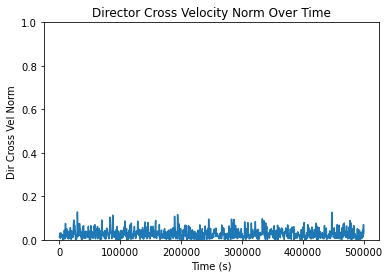

In [6]:
dir_cross_vel_norm = get_dir_cross_vel_norm(exp_data)
plt.plot(times, np.abs(dir_cross_vel_norm))
plt.title('Director Cross Velocity Norm Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Dir Cross Vel Norm')
plt.ylim(0,1)
save_fig_pdf(os.path.join(run_path, 'dir_cross_vel_norm.pdf'))

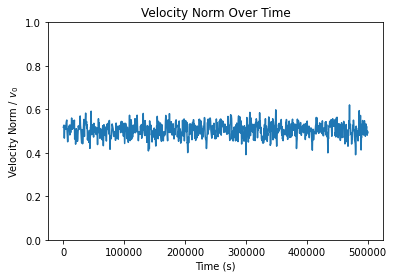

In [7]:
plt.plot(times, np.average(np.sqrt(exp_data['vx']**2 + exp_data['vy']**2)/v0, axis=1))
plt.title('Velocity Norm Over Time')
plt.xlabel('Time (s)')
plt.ylabel(r'Velocity Norm / $v_0$')
plt.ylim(0,1)
plt.show()

In [8]:
analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
with open(os.path.join(analysis_data_dir, 'local_packing_hist.npy'), 'rb') as local_packing_file:
    local_packing_fraction = np.load(local_packing_file)

In [9]:
print(local_packing_fraction.shape)

(1000, 5, 5)


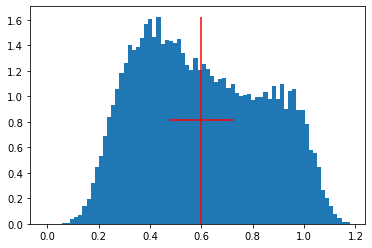

In [16]:
num_bins_along_dim = int(box_length/14)
mean, std_dev, bin_centers = get_packing_mean_and_std_dev(local_packing_fraction[950:,:,:], num_bins_along_dim, box_length, particle_area)
bin_edges = edges_from_centers_linear(bin_centers)
y, _, _ = plt.hist(local_packing_fraction.flatten(), bins=bin_edges, density=True)
plt.vlines(mean, ymin=0, ymax=y.max(), color='red')
plt.hlines(y=y.max()/2, xmin=mean-std_dev/2, xmax=mean+std_dev/2, colors='r')

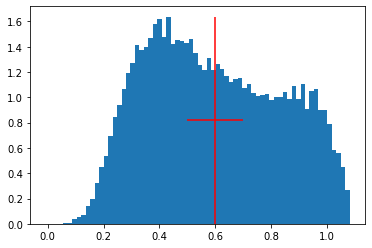

In [24]:
num_bins_along_dim = int(box_length/14)
mean, std_dev, bin_centers = get_packing_mean_and_std_dev(local_packing_fraction[900,:,:], num_bins_along_dim, box_length, particle_area)
bin_edges = edges_from_centers_linear(bin_centers)
y, _, _ = plt.hist(local_packing_fraction.flatten(), bins=bin_edges, density=True)
plt.vlines(mean, ymin=0, ymax=y.max(), color='red')
plt.hlines(y=y.max()/2, xmin=mean-std_dev/2, xmax=mean+std_dev/2, colors='r')

### Plot Distribution of Quantities for Entire Particle Simulation

In [7]:
def get_dir_cross_vel_norm_per_particle(exp_data):
    """
    Computes the average across particles of $\vec{v}_i \cross \vec{n}_i / ||\vec{v}_i||$
    """
    nx_data = exp_data['nx'] #shape: [num of time snapshots, num of particles]
    ny_data = exp_data['ny']
    vx_data = exp_data['vx'] #shape: [num of time snapshots, num of particles]
    vy_data = exp_data['vy']

    dir_cross_vel_norm_per_particle = np.abs((nx_data*vy_data-ny_data*vx_data)/np.sqrt(vx_data**2 + vy_data**2))
    
    return dir_cross_vel_norm_per_particle

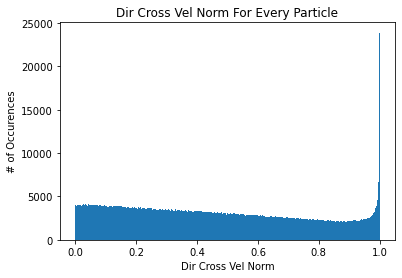

In [8]:
dir_cross_vel_norm_hist_data = get_dir_cross_vel_norm_per_particle(exp_data).flatten()
plt.hist(dir_cross_vel_norm_hist_data, bins=1000)
plt.xlabel('Dir Cross Vel Norm')
plt.ylabel('# of Occurences')
plt.title('Dir Cross Vel Norm For Every Particle')
plt.show()

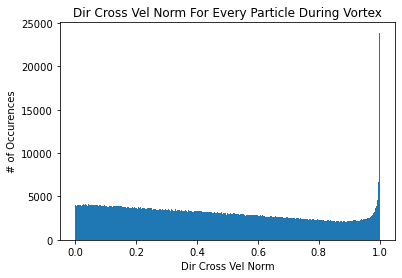

In [9]:
cutoff = 0.3
dir_cross_vel_norm_over_time = np.average(get_dir_cross_vel_norm_per_particle(exp_data), axis=1)
dir_cross_vel_norm_vortex_hist_data = get_dir_cross_vel_norm_per_particle(exp_data)[dir_cross_vel_norm_over_time > cutoff, :].flatten()
plt.hist(dir_cross_vel_norm_vortex_hist_data, bins=1000)
plt.xlabel('Dir Cross Vel Norm')
plt.ylabel('# of Occurences')
plt.title('Dir Cross Vel Norm For Every Particle During Vortex')
plt.show()

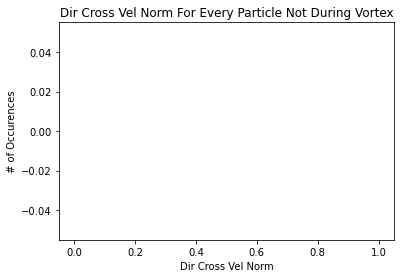

In [10]:
dir_cross_vel_norm_over_time = np.average(get_dir_cross_vel_norm_per_particle(exp_data), axis=1)
dir_cross_vel_norm_no_vortex_hist_data = get_dir_cross_vel_norm_per_particle(exp_data)[dir_cross_vel_norm_over_time < cutoff, :].flatten()
plt.hist(dir_cross_vel_norm_no_vortex_hist_data, bins=1000)
plt.xlabel('Dir Cross Vel Norm')
plt.ylabel('# of Occurences')
plt.title('Dir Cross Vel Norm For Every Particle Not During Vortex')
plt.show()

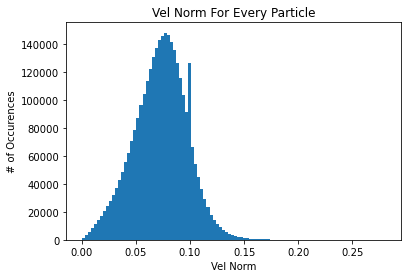

In [11]:
vel_norm_hist_data = np.sqrt(exp_data['vx']**2 + exp_data['vy']**2).flatten()
plt.hist(vel_norm_hist_data, bins=100)
plt.xlabel('Vel Norm')
plt.ylabel('# of Occurences')
plt.title('Vel Norm For Every Particle')
plt.show()

### Analyze Packing Fraction and Phase Separation

In [12]:
num_bins_along_dim = 10

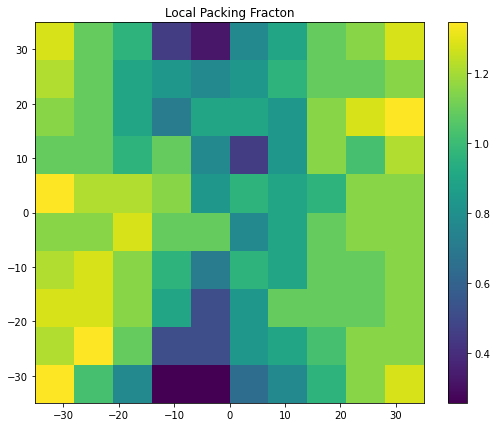

Average packing fraction over simulation: 1.000


In [13]:
#Local Packing Fraction for Single Snapshot
fig = plt.figure(figsize=(8.7,7))
ax = fig.add_subplot()
ax.set_title('Local Packing Fracton')
local_packing_fraction, x_edges, y_edges = get_local_packing_fraction(exp_data, num_bins_along_dim, box_length, particle_area)
X, Y = np.meshgrid(x_edges, y_edges)
pcm = ax.pcolormesh(X, Y, local_packing_fraction[0])
fig.colorbar(pcm, ax=ax)
plt.show()
print(f'Average packing fraction over simulation: {np.average(local_packing_fraction):.3f}')

In [14]:
"""
Get packing fraction histogram
"""
#Get increase in local packing fraction by adding single particle to local box
bin_area = (box_length/num_bins_along_dim)**2
delta_packing_fraction = particle_area / bin_area

#Each bin in hist corresponds to packing fraction from integer particles in local box
bin_centers = delta_packing_fraction*np.arange(0, np.ceil(np.max(local_packing_fraction)/delta_packing_fraction)+1)
bin_edges = edges_from_centers_linear(bin_centers)

#Calculate histogram
hist_values, _ = np.histogram(local_packing_fraction.flatten(), bins=bin_edges, density=True)

In [15]:
"""
Find two peaks with largest prominence of histogram  
"""
from scipy.signal import find_peaks, peak_prominences
peaks_indices, _ = find_peaks(hist_values)
prominences, _, _ = peak_prominences(hist_values, peaks_indices)
largest_peaks_indices = peaks_indices[np.argsort(-prominences)[:2]]

In [16]:
prominences

array([1.66585728])

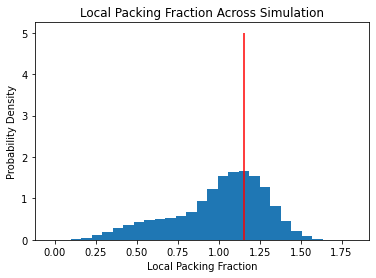

In [17]:
plt.hist(local_packing_fraction.flatten(), bins=bin_edges, density=True)
for peak_index in largest_peaks_indices:
    plt.vlines(bin_centers[peak_index], ymin=0, ymax=5, color='red')
plt.xlabel('Local Packing Fraction')
plt.ylabel('Probability Density')
plt.title('Local Packing Fraction Across Simulation')
plt.show()

In [18]:
peak_distance = np.abs(bin_centers[largest_peaks_indices[0]] - bin_centers[largest_peaks_indices[1]])
print(f'Peak Distance (packing fraction): {peak_distance:.3f}')

IndexError: index 1 is out of bounds for axis 0 with size 1

# Now analyze multiple simulations

In [23]:
num_bins_along_dim = 5

save_dir = "/home/ryanlopez/Polar_Align_Big_Phase_Diagrams"
phi = 0.6
v0 = 0.01
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
J_vals = np.logspace(-3, 0, num=13)
Dr_vals = np.logspace(-3, 0, num=13)
for J in J_vals:
    for Dr in Dr_vals:
        #Load data
        run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, D_r)
        run_dir = os.path.join(save_dir, exp_folder_name, run_folder_name)
        snapshot_dir = os.path.join(run_dir, 'snapshot_data')
        run_desc_filename = os.path.join(run_dir, 'run_desc.json')
        single_stats_filename = os.path.join(run_dir, 'single_stats.json')
        new_single_stats_filename = os.path.join(run_dir, 'new_single_stats.json')

        #Load data
        with open(run_desc_filename, 'r') as run_desc_file:
            run_desc = json.loads(run_desc_file.read())
        with open(single_stats_filename, 'r') as single_stats_file:
            single_stats = json.loads(single_stats_file.read())
        box_length = run_desc['L']
        particle_area = np.pi*run_desc['radius']**2
        exp_data = rd.get_exp_data(snapshot_dir)

        #Calculate peak distance
        peak_distance = get_packing_hist_peak_distance(exp_data, num_bins_along_dim, box_length, particle_area)

        #Save to new json file
        single_stats['packing_peak_distance'] = peak_distance
        with open(new_single_stats_filename, 'w') as new_single_stats_file:
            new_single_stats_file.write(json.dumps(single_stats))
        print(f'Finished {os.path.join(exp_folder_name, run_folder_name)}')

Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0010_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0018_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0018_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0018_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.0100/J=0.0018_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.01

KeyboardInterrupt: 

In [33]:
def load_statistic_data(value_key, Dr_vals, J_vals, exp_dir):
    statistic_values = []
    for D_r in Dr_vals:
        row_of_values = []
        for J in J_vals:
            single_simulation_stats_filename = os.path.join(exp_dir, "J=%.4f_and_Dr=%.4f"%(J, D_r), 'new_single_stats.json')
            with open(single_simulation_stats_filename) as stats_file:
                stats = json.loads(stats_file.read())
            row_of_values.append(stats[value_key])
        statistic_values.append(row_of_values)
    statistic_values = np.array(statistic_values)
    return statistic_values

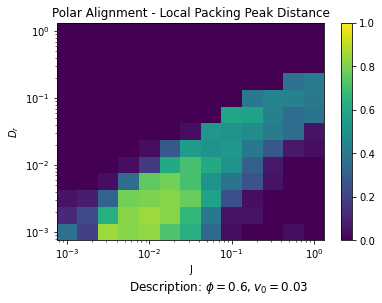

In [34]:
phi = 0.6
v0 = 0.03
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
exp_dir = os.path.join(save_dir, exp_folder_name)
packing_dist_vals = load_statistic_data('packing_peak_distance', Dr_vals, J_vals, exp_dir)
J_edges = edges_from_centers_log(J_vals)
Dr_edges = edges_from_centers_log(Dr_vals)
fig, ax = plt.subplots()
plot = plt.pcolormesh(J_edges, Dr_edges, packing_dist_vals, vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
plt.title('Polar Alignment - Local Packing Peak Distance')
plt.xlabel('J')
plt.ylabel(r'$D_r$')
fig.text(.5, -0.05, r'Description: $\phi=0.6, v_0=0.03$', ha='center', fontsize=12)
plt.colorbar(plot)
save_fig_pdf(os.path.join(exp_dir, 'peak_distance_phase_diagram_1.pdf'))

In [ ]:
save_dir = "/home/ryanlopez/Polar_Align_Vary_Phi_V_Saved_Data2"

fig, axs = plt.subplots(len(phi_vals), len(v0_vals), figsize=(14,14))
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
fig.suptitle('Polar Alignment - Local Packing Peak Distance', fontsize=22)
for v0_index, v0 in enumerate(v0_vals):
    for phi_index, phi in enumerate(phi_vals):
        #Load Data
        exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
        exp_dir = os.path.join(save_dir, exp_folder_name)
        vicsek_vals = load_statistic_data('packing_peak_distance', Dr_vals, J_vals, exp_dir)

        #Make plot
        axs[phi_index, v0_index].set_xscale('log')
        axs[phi_index, v0_index].set_yscale('log')
        ax = axs[phi_index, v0_index].pcolormesh(xedges, yedges, vicsek_vals, vmin=0, vmax=1)
        plt.colorbar(ax, ax=axs[phi_index, v0_index])
        axs[phi_index, v0_index].set_xlabel(r'J')
        axs[phi_index, v0_index].set_ylabel(r'$D_r$')
        if phi_index == 0:
            axs[phi_index, v0_index].set_title(f'v0={v0:.2e}', fontsize=18)
        if v0_index == 0:
            axs[phi_index, v0_index].set_ylabel(f'phi={phi:.2e}', fontsize=18)
save_fig_pdf(os.path.join(save_dir, 'polar_peak_distance_diagrams.pdf'))

In [ ]:
peak_distance_params = []
for dr_index, D_r in enumerate(np.flip(D_r_vals)):
    local_packing_order_param_row = []
    for j_index, J in enumerate(J_vals):
        packing_fractions = local_packing_fraction_data[dr_index][j_index][0]
        bin_edges, bin_centers, largest_peaks_indices = get_packing_dist_details(packing_fractions, box_length, num_bins_along_dim, 
                                                                                particle_area)
        if len(largest_peaks_indices) == 1:
            local_packing_order_param_row.append(0)
        else:
            peak_distance = np.abs(bin_centers[largest_peaks_indices[1]]-bin_centers[largest_peaks_indices[0]])
            local_packing_order_param_row.append(peak_distance)
    local_packing_order_param.append(local_packing_order_param_row)

fig, ax = plt.subplots(figsize=(8,6))
x_bins = edges_from_centers_log(np.flip(D_r_vals))
y_bins = edges_from_centers_log(J_vals)
xedges, yedges = np.meshgrid(x_bins,y_bins)
plt.xscale('log')
plt.yscale('log')
plot = ax.pcolormesh(np.flip(xedges), np.flip(yedges), np.array(local_packing_order_param), vmin=0, vmax=1)
plt.colorbar(plot)
plt.title('Packing Fraction Difference Between Peaks')
plt.show()

# Old Code

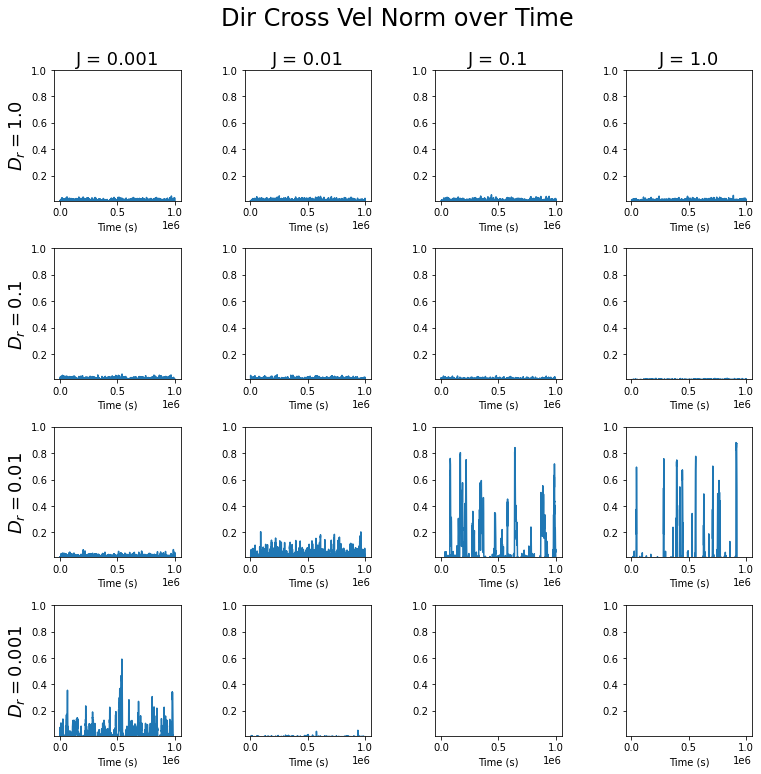

In [23]:
fig, axs = plt.subplots(4,4, figsize = (11, 11))
fig.tight_layout(pad=3.0)
fig.suptitle('Dir Cross Vel Norm over Time', fontsize = 24)
for dr_index, D_r in enumerate(D_r_vals):
    for j_index, J in enumerate(J_vals):
        axs[3-dr_index, j_index].plot(times, dir_cross_vel_norm_data[dr_index][j_index])
        axs[3-dr_index, j_index].set_ylim(0,1)
        axs[3-dr_index, j_index].set_xlabel('Time (s)')
        if j_index == 0:
            axs[3-dr_index, j_index].set_ylabel(r'$D_r = $' + str(D_r), fontsize = 18)
        if dr_index == 3:
            axs[3-dr_index, j_index].set_title(f"J = {J}", fontsize = 18)
        axs[3-dr_index, j_index].set_ylim(1e-2, 1)
plt.subplots_adjust(top=0.9)
base_filename = os.path.join(save_dir, 'phase_diagrams')
#save_fig_pdf(base_filename, "dir_cross_vel_over_time.pdf")

In [58]:
def get_packing_dist_details(local_packing_fraction, box_length, num_bins_along_dim, particle_area):
    bin_area = (box_length/num_bins_along_dim)**2
    delta_packing_fraction = particle_area / bin_area
    #Each bin in hist corresponds to packing fraction from integer particles in local box
    bin_centers = delta_packing_fraction*np.arange(0, np.ceil(np.max(local_packing_fraction)/delta_packing_fraction)+1)
    bin_edges = edges_from_centers_linear(bin_centers)
    #Calculate histogram
    hist_values, _ = np.histogram(local_packing_fraction.flatten(), bins=bin_edges, density=True)
    peaks_indices, _ = find_peaks(hist_values, prominence=0.05)
    prominences, _, _ = peak_prominences(hist_values, peaks_indices)
    largest_peaks_indices = peaks_indices[np.argsort(-prominences)[:2]]
    return bin_edges , bin_centers, largest_peaks_indices

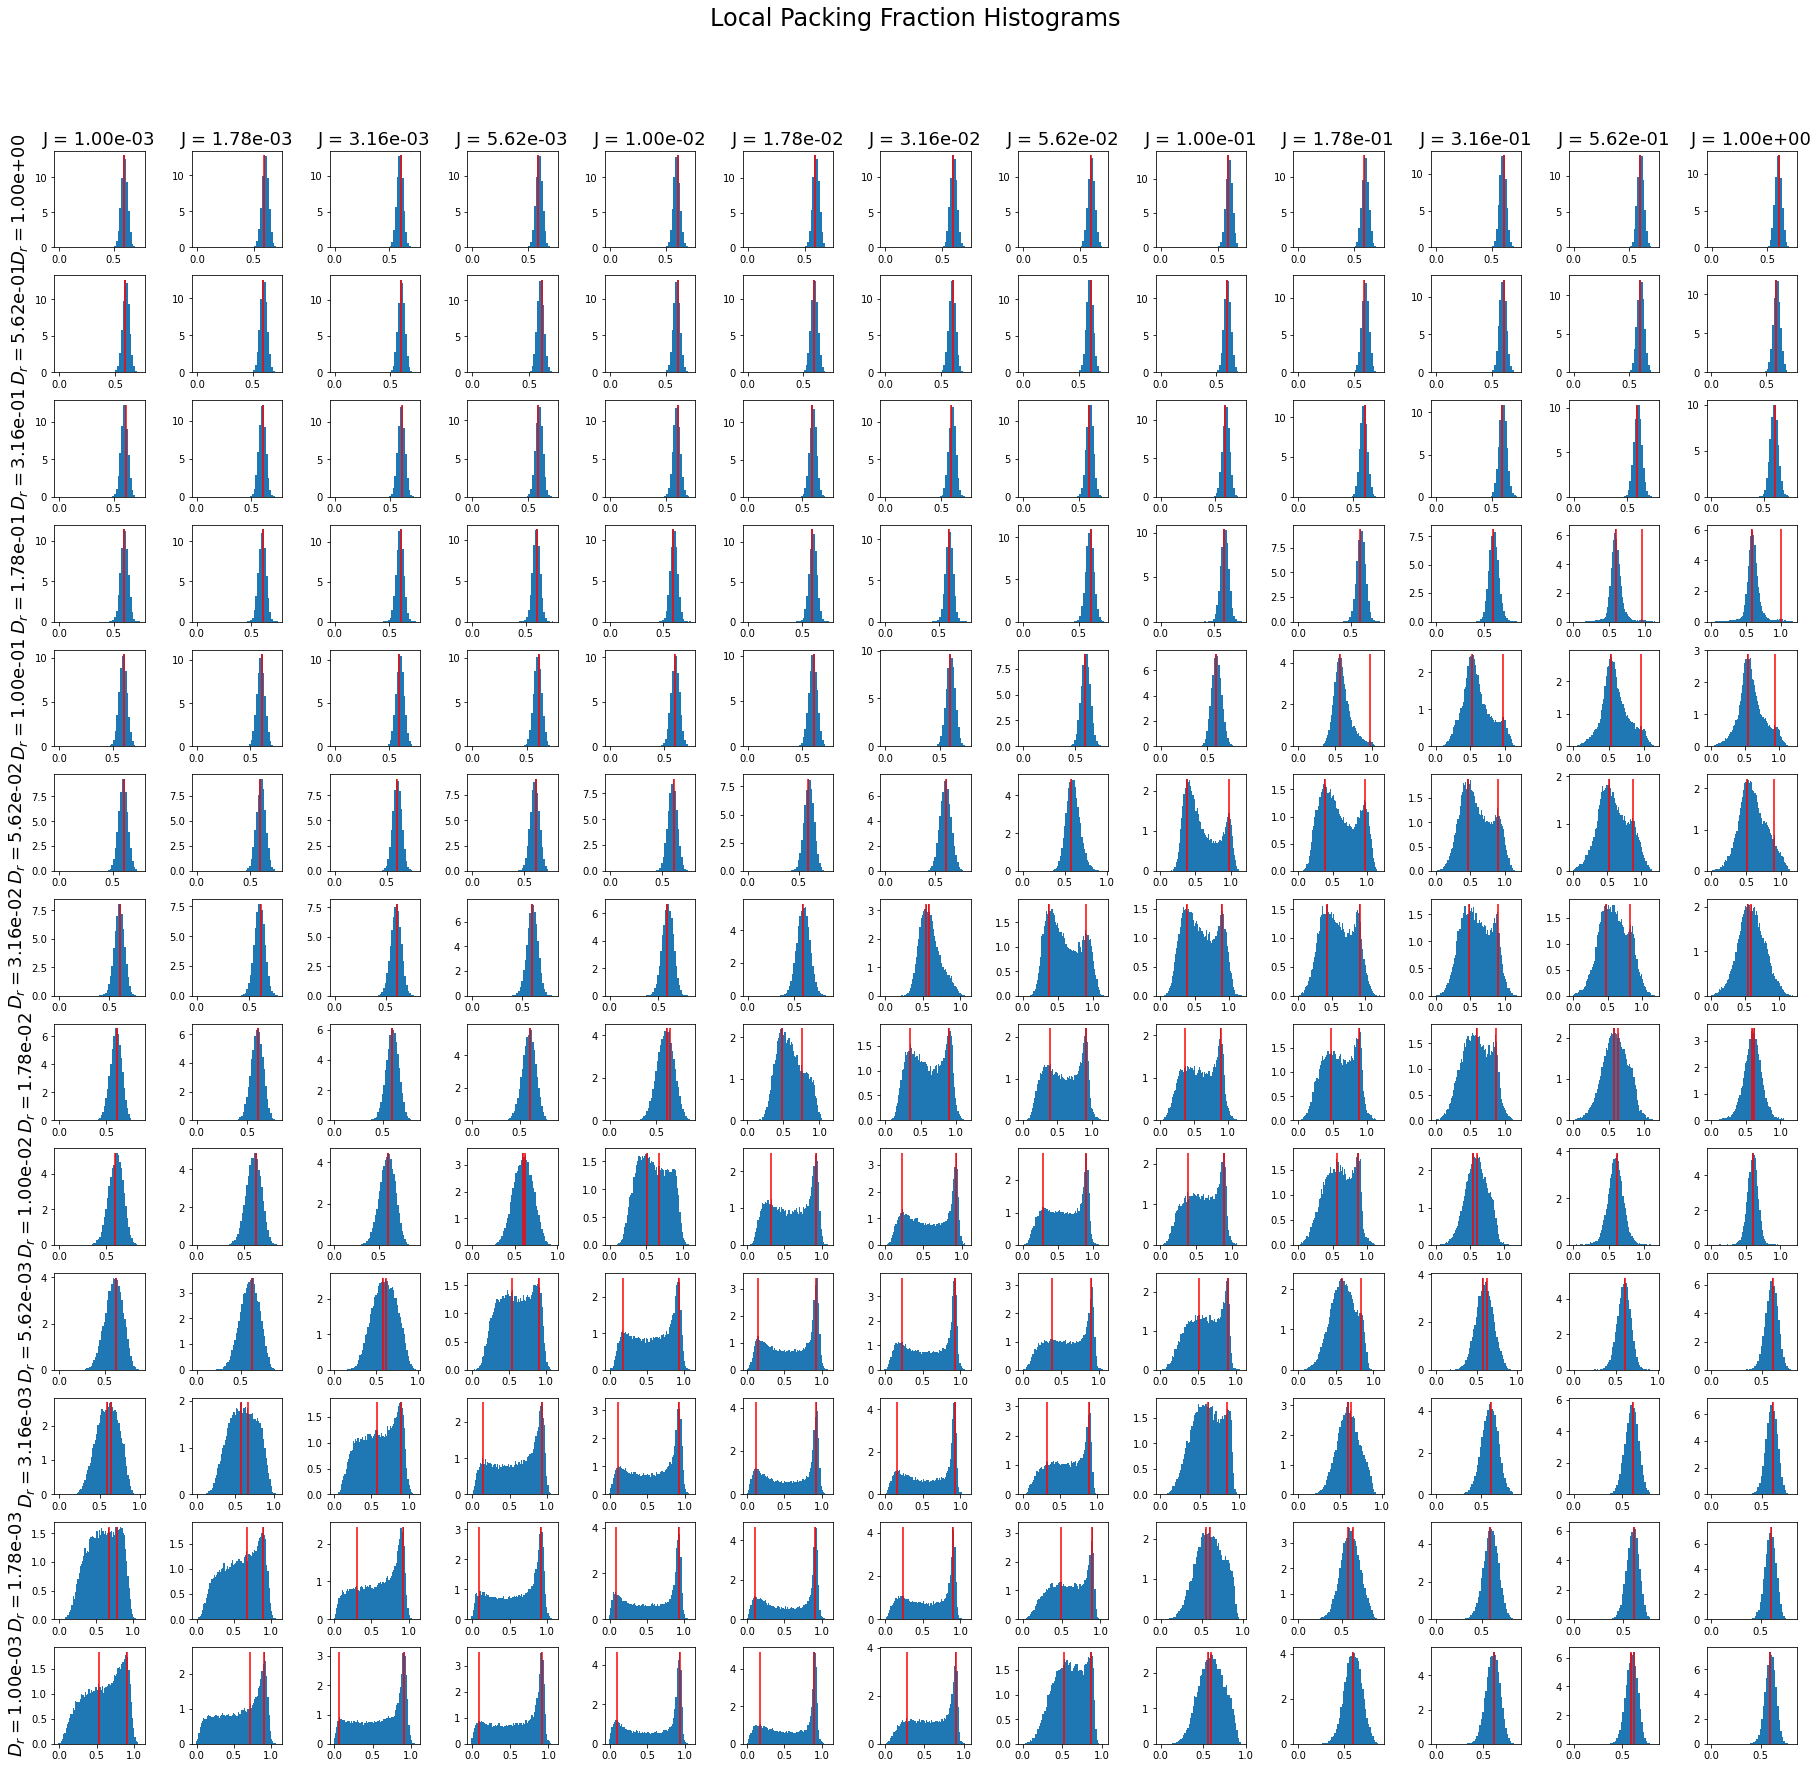

In [64]:
fig, axs = plt.subplots(13,13, figsize = (25, 25))
fig.tight_layout(pad=0.5)
fig.suptitle('Local Packing Fraction Histograms', fontsize = 24)
for dr_index, D_r in enumerate(np.flip(D_r_vals)):
    for j_index, J in enumerate(J_vals):
        packing_fractions = local_packing_fraction_data[dr_index][j_index][0]
        bin_edges, bin_centers, largest_peaks_indices = get_packing_dist_details(packing_fractions, box_length, num_bins_along_dim, 
                                                                                particle_area)
        y, x, _ = axs[dr_index, j_index].hist(packing_fractions.flatten(), bins=bin_edges, density=True)
        for peak_index in largest_peaks_indices:
            axs[dr_index, j_index].vlines(bin_centers[peak_index], ymin=0, ymax=y.max(), color='red')
        if j_index == 0:
            axs[dr_index, j_index].set_ylabel(r'$D_r = $' + f'{D_r:.2e}', fontsize = 15)
        if dr_index == 0:
            axs[dr_index, j_index].set_title(f"J = {J:.2e}", fontsize = 15)
plt.subplots_adjust(top=0.9)
base_filename = os.path.join(save_dir, 'phase_diagrams')
#save_fig_pdf(base_filename, "dir_cross_vel_over_time.pdf")

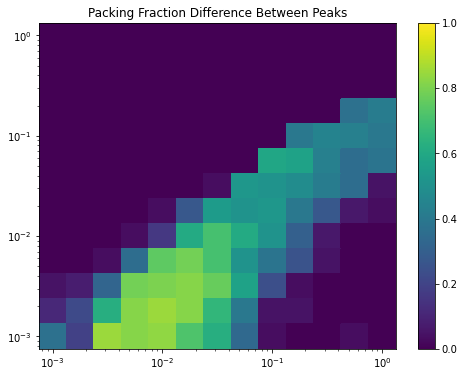

In [109]:
local_packing_order_param = []
for dr_index, D_r in enumerate(np.flip(D_r_vals)):
    local_packing_order_param_row = []
    for j_index, J in enumerate(J_vals):
        packing_fractions = local_packing_fraction_data[dr_index][j_index][0]
        bin_edges, bin_centers, largest_peaks_indices = get_packing_dist_details(packing_fractions, box_length, num_bins_along_dim, 
                                                                                particle_area)
        if len(largest_peaks_indices) == 1:
            local_packing_order_param_row.append(0)
        else:
            peak_distance = np.abs(bin_centers[largest_peaks_indices[1]]-bin_centers[largest_peaks_indices[0]])
            local_packing_order_param_row.append(peak_distance)
    local_packing_order_param.append(local_packing_order_param_row)

fig, ax = plt.subplots(figsize=(8,6))
x_bins = edges_from_centers_log(np.flip(D_r_vals))
y_bins = edges_from_centers_log(J_vals)
xedges, yedges = np.meshgrid(x_bins,y_bins)
plt.xscale('log')
plt.yscale('log')
plot = ax.pcolormesh(np.flip(xedges), np.flip(yedges), np.array(local_packing_order_param), vmin=0, vmax=1)
plt.colorbar(plot)
plt.title('Packing Fraction Difference Between Peaks')
plt.show()

In [94]:
np.array(local_packing_order_param)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.36865628, 0.41674188],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.40071335,
        0.44879895, 0.43277042, 0.40071335],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.     

In [2]:
fig, axs = plt.subplots(13,13, figsize = (20, 20))
fig.tight_layout(pad=3.0)
fig.suptitle('Local Packing Fraction Histograms', fontsize = 24)
for dr_index, D_r in enumerate(D_r_vals):
    for j_index, J in enumerate(J_vals):
        packing_fractions = local_packing_fraction_data[dr_index][j_index][0]
        bin_edges, bin_centers, largest_peaks_indices = get_packing_dist_details(packing_fractions, box_length, num_bins_along_dim, 
                                                                                particle_area)
        y, x, _ = axs[3-dr_index, j_index].hist(packing_fractions.flatten(), bins=bin_edges, density=True)
        for peak_index in largest_peaks_indices:
            axs[3-dr_index, j_index].vlines(bin_centers[peak_index], ymin=0, ymax=y.max(), color='red')
        if j_index == 0:
            axs[3-dr_index, j_index].set_ylabel(r'$D_r = $' + str(D_r), fontsize = 18)
        if dr_index == 3:
            axs[3-dr_index, j_index].set_title(f"J = {J}", fontsize = 18)
plt.subplots_adjust(top=0.9)
base_filename = os.path.join(save_dir, 'phase_diagrams')
#save_fig_pdf(base_filename, "dir_cross_vel_over_time.pdf")

NameError: name 'plt' is not defined

In [26]:
#local_packing_fraction_data[0][0] #data, xedges, yedges
local_packing_fraction_data[0][0][0].shape

(2000, 5, 5)

In [27]:

#Get increase in local packing fraction by adding single particle to local box
bin_area = (box_length/num_bins_along_dim)**2
delta_packing_fraction = particle_area / bin_area

#Each bin in hist corresponds to packing fraction from integer particles in local box
bin_centers = delta_packing_fraction*np.arange(0, np.ceil(np.max(local_packing_fraction)/delta_packing_fraction)+1)
bin_edges = edges_from_centers_linear(bin_centers)

#Calculate histogram
hist_values, _ = np.histogram(local_packing_fraction.flatten(), bins=bin_edges, density=True)